In [188]:
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

ver='try4'
gver='basic2'
#dver='cut16'
dver='det'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')
def truncSine_func(x,mu=0.,sigma=1.5,deriv=0):
    t=(x-mu)/sigma
    if deriv==0:
        return np.piecewise(t, [t<-1,(t>=-1)&(t<=1),t>1], [0.,lambda t:1./2.+np.sin(t*np.pi/2.)/2., 1.])
    elif deriv==1:
        # multiplicative factor for the first derivative
        return np.piecewise(t, [t<-1+0.01,(t>=-1+0.01)&(t<=1-0.01),t>1-0.01],[0.,lambda t: np.pi/2./sigma*np.cos(t*np.pi/2.)/(1.+np.sin(t*np.pi/2.)), 0.] )


def sigmoid_func(x,mu=0.,sigma=1.5,deriv=0):
    expx=np.exp(-(x-mu)/sigma)
    if deriv==0:
        # sigmoid function
        return 1./(1. + expx)
    elif deriv==1:
        # multiplicative factor for the first derivative
        return 1./sigma*expx/(1. + expx)

def get_detbias(dets,ells,w_sel,icut,isig,ind):
    """
    Parameters:
        dets:       detection array
        ells:       ellipticity array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function
        inds:       pixel index

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    if use_sig:
        wselb  =  sigmoid_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    out1=np.sum(ells[fnmr1]*wselb*w_sel)
    out2=np.sum(ells[fnmr2]*wselb*w_sel)
    return out1,out2

def get_detbias_list(dets,ells,w_sel,indsl,cutsl,bcutl):
    """
    get detection bias due to lower boundar cuts
    Parameters:
        dets:       ndarray
                    detection array
        ells:       ndarray
                    ellipticity array
        w_sel:      ndarray
                    selection weight
        indsl:      list
                    a list of pixel index
        cutsl:      list
                    a list of selection cuts (sigmoid mu)
        bcutl:      list
                    a list of width of sigmoid functions
    """
    ncut = len(indsl) # assert
    assert len(cutsl)==ncut, 'number of cuts does not match'
    assert len(bcutl)==ncut, 'number of boundary bin size does not match'

    cor1Sum=0.  # initialize the correction terms
    cor2Sum=0.
    for _ in range(ncut):
        fnmv =  'pdet_v%d%d' %indsl[_]
        bcut  =  bcutl[_]
        icut  =  cutsl[_]
        print('apply cut on %s at %.3f' %(fnmv,icut))
        c1,c2=get_detbias(dets,ells,w_sel,icut,bcut,indsl[_])
        cor1Sum+=c1
        cor2Sum+=c2
    return cor1Sum,cor2Sum

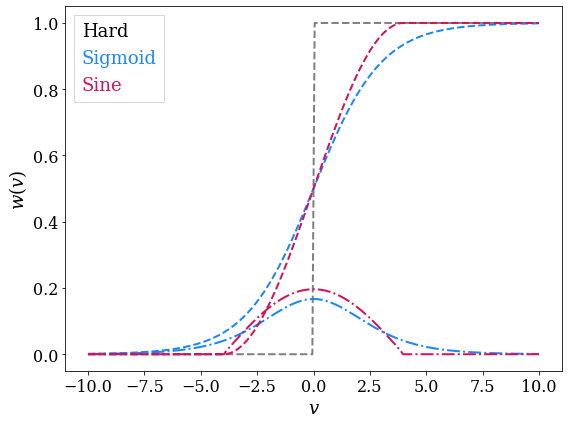

In [143]:
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
x = np.linspace(-10, 10, 200)
y=np.piecewise(x, [x<0.,x>=0.], [0.,1.])
ax.plot(x,y,color=pltutil.colors[0],ls='--',label='Hard',alpha=0.5)
y=sigmoid_func(x)
z=y*sigmoid_func(x,deriv=1)
ax.plot(x,y,color=pltutil.colors[1],ls='--',label='Sigmoid')
ax.plot(x,z,color=pltutil.colors[1],ls='-.')
y=truncSine_func(x,sigma=4.)
z=y*truncSine_func(x,sigma=4.,deriv=1)
ax.plot(x,y,color=pltutil.colors[2],ls='--',label='Sine')
ax.plot(x,z,color=pltutil.colors[2],ls='-.')

ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$w(v)$')
leg=ax.legend(fontsize=18,handlelength=0,handletextpad=0,fancybox=False,markerscale=0)
for it,text in enumerate(leg.get_texts()):
    cc=leg.legendHandles[it].get_color()
    text.set_color(cc)
    
plt.tight_layout()
fig.savefig('../../html/sel_fun.pdf')


In [195]:
# read noiseless data
nver='var8em3' # 'var0em0'#
outNN1=[]
outNN2=[]
for _i in range(400):
    _a1=fitsio.read(os.path.join(simDir,'srcfs_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    #msk1=((_a1['pdet_x']%64-32.)**2.+(_a1['pdet_y']%64-32.)**2.)<4.
    #msk2=((_a2['pdet_x']%64-32.)**2.+(_a2['pdet_y']%64-32.)**2.)<4.
    #_a1=_a1[msk1]
    #_a2=_a2[msk2]
    outNN1.append(_a1)
    outNN2.append(_a2)
    del _a1,_a2#,msk1,msk2
outNN1 =   rfn.stack_arrays(outNN1,usemask=False)
outNN2 =   rfn.stack_arrays(outNN2,usemask=False)
detM1=   pdet.peak2det(outNN1)
detM2=   pdet.peak2det(outNN2)

In [196]:
len(outNN1)

1394108

In [197]:
np.sqrt(0.004)
gc.collect()

1124

In [198]:
Const  =   2000.
if nver=='var4em3':
    noirev=True
else:
    noirev=False
ellM1=   fpfs.fpfsBase.fpfsM2E(outNN1,dets=detM1,const=Const,noirev=noirev)
ellM2=   fpfs.fpfsBase.fpfsM2E(outNN2,dets=detM2,const=Const,noirev=noirev)
gc.collect()

0

In [199]:
len(detM2)

1394166

apply cut on pdet_v22 at 0.040
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
apply cut on pdet_v22 at 0.040
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
1253268.6500426559
apply cut on pdet_v22 at 0.140
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
apply cut on pdet_v22 at 0.140
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
1253268.6500426559
apply cut on pdet_v22 at 0.240
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
apply cut on pdet_v22 at 0.240
apply cut on pdet_v21 at 0.003
apply cut on pdet_v23 at 0.003
apply cut on pdet_v12 at 0.003
apply cut on pdet_v32 at 0.003
1188282.351902642
apply cut on p

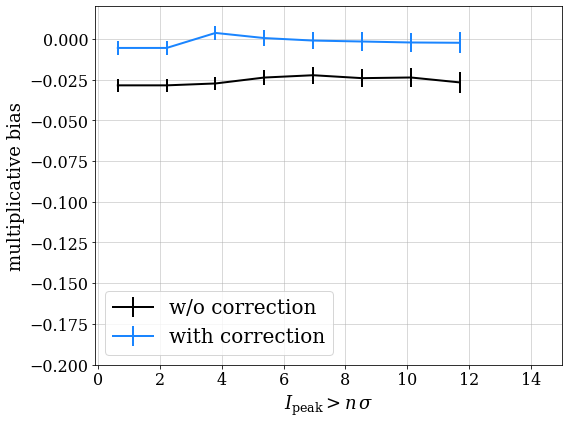

In [200]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
indsAll=[(2,2),(2,1),(2,3),(1,2),(3,2)]

tt = (2,2)
if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
    ax.set_xlim(-0.1,2)
    dcc=0.005
    dcut=0.01
else:
    xlabel=r'$I_{\rm peak}$'
    ax.set_xlim(-0.1,15)
    dcc=0.01
    dcut=0.1
    
cutp=0.003
if use_sig:
    cutn=cutp/3.
else:
    cutn=cutp
    
for i in range(0,8):
    # update cut array
    
    cut=dcut*i+dcc*4
    cutAll=[]
    cutAll.append(cut)
    for _ in range(len(indsAll)-1):
        cutAll.append(cutp)
    dccAll=[]
    dccAll.append(dcc)
    for _ in range(len(indsAll)-1):
        dccAll.append(cutn)

    # weight array
    ws1 = np.ones(len(detM1))
    for _ in range(len(cutAll)):
        pn='v%d%d' %indsAll[_]
        if use_sig:
            _wtmp= sigmoid_func(detM1['pdet_%s' %pn],mu=cutAll[_],sigma=dccAll[_])
        else:
            _wtmp= truncSine_func(detM1['pdet_%s' %pn],mu=cutAll[_],sigma=dccAll[_])
        ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    for _ in range(len(cutAll)):
        pn='v%d%d' %indsAll[_]
        if use_sig:
            _wtmp= sigmoid_func(detM2['pdet_%s' %pn],mu=cutAll[_],sigma=dccAll[_])
        else:
            _wtmp= truncSine_func(detM2['pdet_%s' %pn],mu=cutAll[_],sigma=dccAll[_])
        ws2=ws2*_wtmp

    cor1,cor1b = get_detbias_list(detM1,ellM1,ws1,indsAll,cutAll,dccAll)
    cor2,cor2b = get_detbias_list(detM2,ellM2,ws2,indsAll,cutAll,dccAll)
    de   =  np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
    print(np.sum(ws2))
gc.collect()

ax.errorbar(np.array(x),np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x),np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
print(np.array(y2))
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.20,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

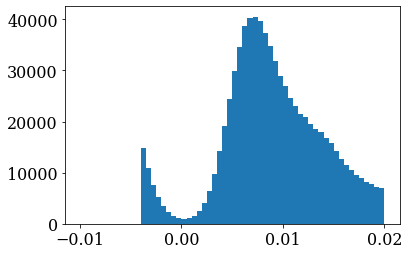

In [187]:
plt.close()
plt.hist(detM1['pdet_v21'],bins=60,range=(-0.01,0.02))
plt.show()